- Generate a grid of FSPS spectra (in age and metallicity)
- perform PCA on this grid
- Perform gaussian processes regression on the coefficients 

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from astropy.cosmology import Planck15 as cosmo

import fsps

from sklearn.decomposition import PCA

In [63]:
sp = fsps.StellarPopulation(zcontinuous=1, sfh=0, logzsol=0.0, dust_type=2)

wl = np.array(sp.get_spectrum(tage=13, peraa=True)).T[:,0]

!! high metallicites blow up the SED, not sure why !!

In [64]:
Nage = 10
NZ = 10
Ndust = 10

ages = np.linspace(2e-1, cosmo.age(0).value, num=Nage)
metallicities = np.log(np.linspace(5e-3, 1.4e-2, num=NZ) / 0.0134)  # log(Z / Zsol)
extinction = np.linspace(1e-1, 3e-1, num=Ndust)  # log(Z / Zsol)

In [66]:
spec = np.zeros((len(ages), len(metallicities), len(extinction), 5994))

for i, a in enumerate(ages):
    for j, Z in enumerate(metallicities):
        for k, e in enumerate(extinction):

            sp.params['logzsol'] = Z
            sp.params['dust2'] = e

            spec[i,j,k] = np.log10(sp.get_spectrum(tage=a, peraa=True)[1])


In [5]:
# plt.semilogx(wl, spec[0,0])

In [6]:
# for s in spec.reshape((len(ages)*len(metallicities), 5994)):
#     plt.semilogx(wl, s, alpha=0.1)


## PCA

In [68]:
shape = len(ages) * len(metallicities) * len(extinction)

In [69]:
comps = 40
spectra_pca = PCA(n_components=comps)
spectra_pca.fit(spec.reshape((shape, 5994)))

PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

/home/chris/anaconda/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


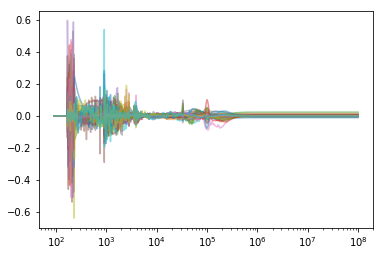

In [70]:
# plt.semilogx(wl, spectra_pca.mean_, label='mean', color='black')

for component in spectra_pca.components_:
    plt.semilogx(wl, component, alpha=0.5)

plt.legend()

In [71]:
coeffs = np.array(spectra_pca.transform(spec.reshape((shape, 5994))))
coeffs = coeffs.reshape((len(ages),len(metallicities),len(extinction),comps))
coeffs.shape

(10, 10, 10, 40)

13.7976166641 -0.803495237729 0.122222222222


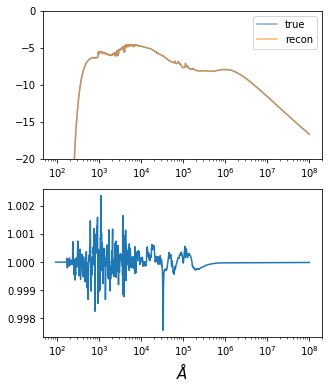

In [76]:
# reconstruct SFH
i = 9
j = 1
k = 1

print(ages[i], metallicities[j], extinction[k])

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,6))

ax1.semilogx(wl, spec[i,j,k], label='true', alpha=0.6)
ax1.semilogx(wl, spectra_pca.mean_ + np.dot(coeffs[i,j,k], spectra_pca.components_), label='recon', alpha=0.6)

ax1.legend()

ax1.set_ylim(-20, 0)

ax2.semilogx(wl, spec[i,j,k] / (spectra_pca.mean_ + np.dot(coeffs[i,j,k], spectra_pca.components_)))

ax2.set_xlabel('$\AA$', size=15)

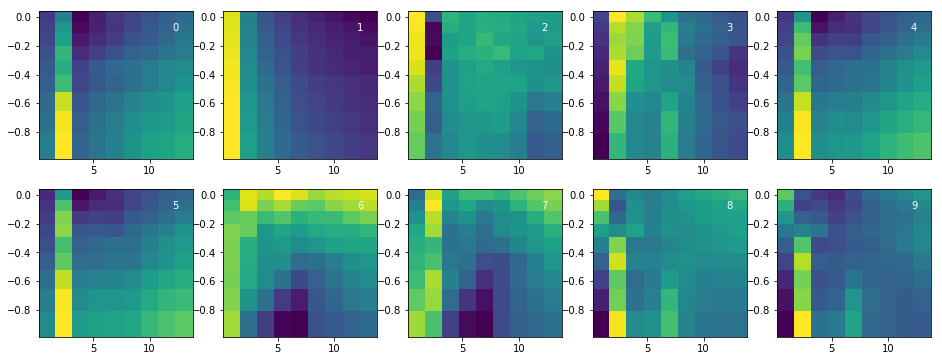

In [81]:
fig, axes = plt.subplots(2,5, figsize=(16,6))

axes = axes.flatten()

for i, ax in enumerate(axes):
    img = ax.pcolormesh(ages, metallicities, coeffs[:,:,1,i].T)
    ax.text(12, -0.1, i, color='white')
    

## Regression

In [107]:
from scipy.interpolate import interp2d, Rbf, RegularGridInterpolator

In [110]:
f = [None] * comps

xx, yy, zz = np.meshgrid(ages, metallicities, extinction)

for i in range(comps):
#     f[i] = interp2d(ages, metallicities, coeffs[:,:,i].T, kind='cubic')
    f[i] = RegularGridInterpolator((ages, metallicities, extinction), coeffs[:,:,:,i])#, kind='cubic')
#     f[i] = Rbf(xx, yy, zz, coeffs[:,:,:,i].T)


In [117]:
test = RegularGridInterpolator((ages, metallicities, extinction), coeffs[:,:,:,0])

test(a,Z,e)

TypeError: __call__() takes from 2 to 3 positional arguments but 4 were given

In [121]:
test((a,Z,e))

array(-47.29322843849854)

In [125]:
i = 5
j = 9
k = 8

a = ages[i]
Z = metallicities[j]
e = extinction[k]

# print(coeffs[i,j])

a = 11.1
Z = -0.07
e = 0.2

print(a,Z,e)

interp_coeffs = np.array([f[c]((a, Z, e)) for c in np.arange(comps)]).flatten()
print(interp_coeffs)

11.1 -0.07 0.2
[ -7.46804921e+00  -3.13013421e+01  -9.36244369e+00  -3.04029136e+00
   1.54426348e+00  -3.36916328e+00  -4.15395510e-01   1.94742458e+00
   1.10644760e-01   1.48173545e+00   1.30583363e-01  -1.36551405e-02
   4.79750097e-02  -4.17409987e-01   1.08390566e-01   6.11048400e-02
   3.28676547e-01   2.12064425e-02  -1.31723724e-01   2.90325199e-01
   4.40472267e-02   1.39407711e-04   2.20056941e-02   6.03062809e-02
  -2.85895058e-02   4.67406861e-05  -3.07921061e-02  -1.31234560e-02
  -3.61567581e-02   4.34414407e-02   5.69744302e-03  -1.65774354e-02
  -1.88408936e-02  -2.21488649e-02   2.57960001e-03  -1.12370837e-02
   1.51403442e-02   5.17965665e-02   1.28724412e-02   1.29269533e-02]


In [126]:
sp.params['logzsol'] = Z
sp.params['dust2'] = e

test_spec = np.log10(sp.get_spectrum(tage=a, peraa=True)).T[:,1]

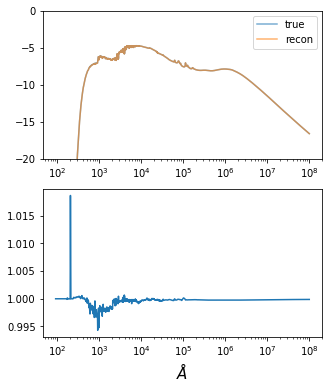

In [127]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(5,6))

ax1.semilogx(wl, test_spec, label='true', alpha=0.6)
ax1.semilogx(wl, spectra_pca.mean_ + np.dot(interp_coeffs, spectra_pca.components_), label='recon', alpha=0.6)

ax1.legend()

ax1.set_ylim(-20, 0)

ax2.semilogx(wl, test_spec / (spectra_pca.mean_ + np.dot(interp_coeffs, spectra_pca.components_)))

ax2.set_xlabel('$\AA$', size=15)